In [30]:
import pandas as pd 
import matplotlib.pyplot as plt 


In [4]:
df = pd.read_csv("Results.csv")
cols = df.columns[1:]
df = df[cols]
df

,username,creator_id,predicted_nationality
0,user4260512796791,138,NaN
1,flyiiingtwins,711,NaN
2,dodooarts,712,NaN
3,xebu.dance,713,Philippines
4,melissalimes,714,South Africa
...,...,...,...
329995,kamelyapirates,1294159,Turkey
329996,estefaniemarie888,1294160,Mexico
329997,lvm.rhl21,1294161,NaN
329998,tiktokwithmichael,1294162,United States


# her column için null ne non null sayıları

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   username               329999 non-null  object
 1   creator_id             330000 non-null  int64 
 2   predicted_nationality  134068 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.6+ MB


### % kaç tahmin edildi?

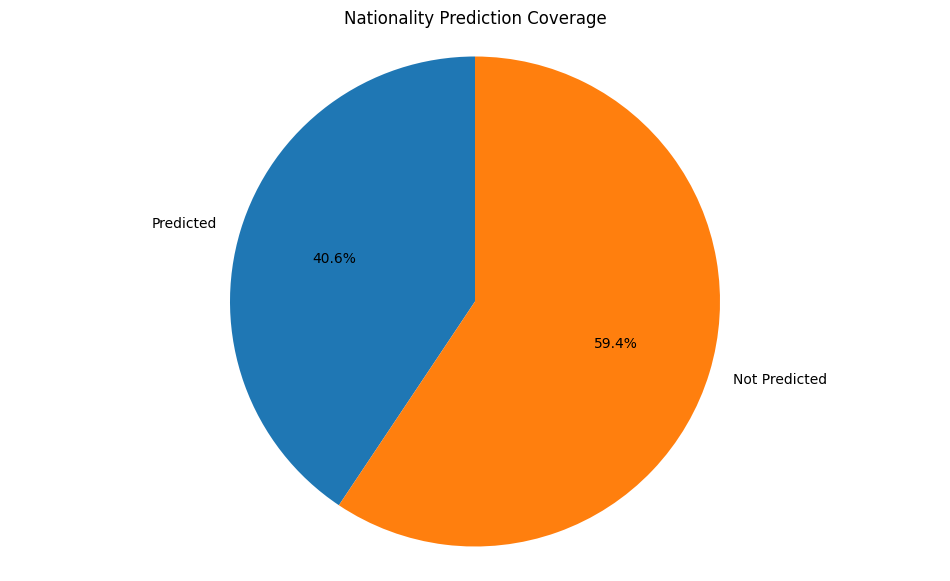

In [14]:
total_count = len(df)

predicted_count = df["predicted_nationality"].notna().sum()
unpredicted_count = df["predicted_nationality"].isna().sum()

predicted_ratio = predicted_count / total_count * 100

labels = ["Predicted", "Not Predicted"]
sizes = [predicted_count, unpredicted_count]

plt.figure(figsize=(12,7))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Nationality Prediction Coverage")
plt.axis("equal")  
plt.show()

# Toplam kaç farklı ülke tahmin edildi?

In [15]:
df["predicted_nationality"].nunique()

327

## Bu tahminler neler?

In [16]:
df["predicted_nationality"].unique()

array([nan, 'Philippines', 'South Africa', 'South Korea', 'United States',
       'Thailand', 'Spain', 'Peru', 'France', 'Brazil', 'Senegal',
       'Denmark', 'Netherlands', 'Japan', 'Canada', 'Portugal', 'Israel',
       'Wales', 'Bolivia', 'Iran', 'Venezuela', 'Saudi Arabia',
       'Indonesia', 'Colombia', 'Ukraine', 'Italy', 'Ireland',
       'Australia', 'United Kingdom', 'Vietnam', 'Myanmar', 'Cambodia',
       'Algeria', 'United Arab Emirates', 'Russian Federation',
       'Azerbaijan', 'Russia', 'Turkey', 'Poland', 'Mexico', 'Angola',
       'Sweden', 'Nigeria', 'Haiti', 'Democratic Republic of the Congo',
       'Jamaica', 'Nicaragua', 'Tanzania', 'Costa Rica', 'Nepal',
       'Germany', 'New Zealand', 'Kazakhstan', 'Chile', 'Ghana',
       'Dominican Republic', 'Uganda', 'Singapore', 'Guinea-Bissau',
       'Saint Vincent and the Grenadines', 'Madagascar', 'Uruguay',
       'Kenya', 'Mauritius', 'Norway', 'Slovenia', 'Palestinian',
       'Abra (Philippines)', 'Scotland', 'C

### Örneğin zor tahminlerden Timor-Leste sonuçları

In [17]:
df[df["predicted_nationality"] == "Timor-Leste"]

,username,creator_id,predicted_nationality
1096,9abrielle12,45541,Timor-Leste
5764,alcalicious,51658,Timor-Leste
24504,livio7474,141998,Timor-Leste
27773,lanacortinhal,166002,Timor-Leste
30521,your_vc,170021,Timor-Leste
45083,orchidsalonspa_,207067,Timor-Leste
58521,tibaaa20,250153,Timor-Leste
61747,loja_lejia,300899,Timor-Leste
70557,instahotdili,374980,Timor-Leste
77503,superglowdili,455498,Timor-Leste


## Hangi ülkeden kaç tahmin yapıldı

In [18]:
df["predicted_nationality"].value_counts()

predicted_nationality
Spain                         25654
United States                 12179
Brazil                        10373
Mexico                         7501
Indonesia                      7159
                              ...  
Canadian and South African        1
Venezuelan/Lebanese               1
Latinoamerican                    1
Vanuatu                           1
Cuban/Puerto Rican                1
Name: count, Length: 327, dtype: int64

### 330000 kişi arasında 3000'den fazla tahmin edilen ülkeler

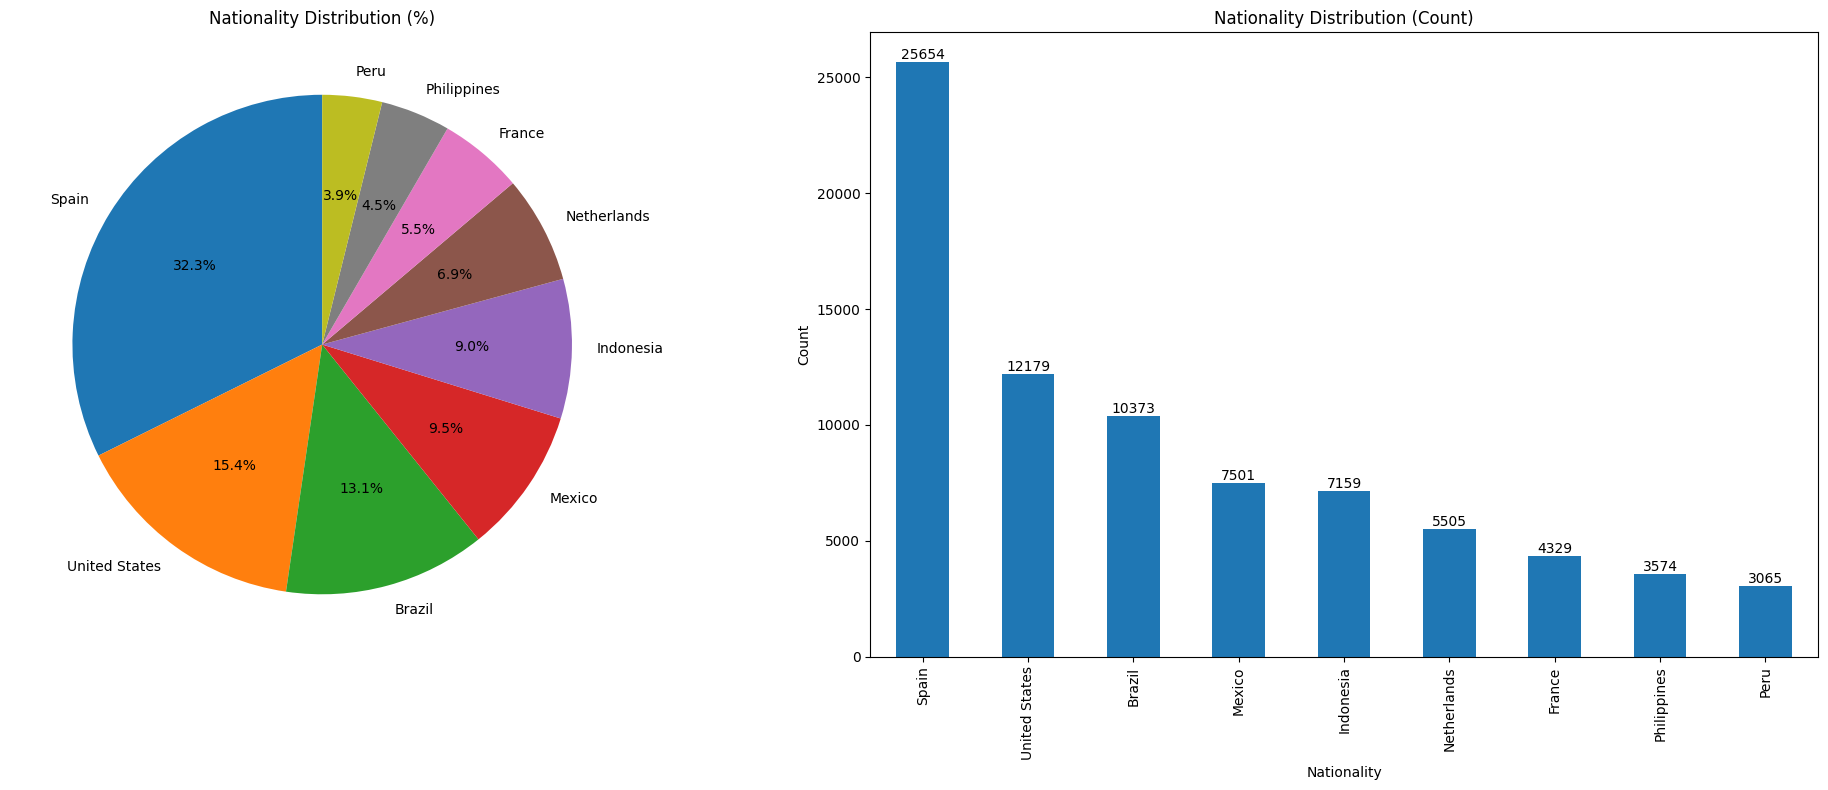

In [19]:
n = 3000


vc = df["predicted_nationality"].value_counts()
vc_filtered = vc[vc > n]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- SOL: Pie chart (% olarak) ---
vc_filtered.plot(
    kind="pie",
    ax=axes[0],
    autopct="%.1f%%",
    startangle=90
)
axes[0].set_title("Nationality Distribution (%)")
axes[0].set_ylabel("")  # Pie chart'ta gereksiz

# --- SAĞ: Bar chart (sayı olarak) ---
bars = vc_filtered.plot(
    kind="bar",
    ax=axes[1]
)
axes[1].set_title("Nationality Distribution (Count)")
axes[1].set_xlabel("Nationality")
axes[1].set_ylabel("Count")

# Bar üstüne sayı yazdır
for bar in bars.patches:
    height = bar.get_height()
    axes[1].annotate(
        f"{int(height)}",
        (bar.get_x() + bar.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


### Çok fazla spain var ilk 30 spain tahmini

In [20]:
df[df["predicted_nationality"] == "Spain"].head(30)

,username,creator_id,predicted_nationality
25,dr.robejose,735,Spain
108,iammedina.t,820,Spain
130,dogos.del.artizar,842,Spain
228,remimartinpr,954,Spain
284,jorgejavier_diaz,1035,Spain
397,agusflei,1154,Spain
400,davidchao.tv,1157,Spain
409,andrea_giselle1311,1166,Spain
414,arlua.r,1171,Spain
421,holamiamorcomoestasmore0,1178,Spain


### Bazı Türk tahminleri (doğrulaması kolay olsun)

In [21]:
df[df["predicted_nationality"].isin(["Turkey", "TR", "Turkiye"])]

,username,creator_id,predicted_nationality
234,ucarteam,960,Turkey
2034,sdnr_cetin,46767,Turkey
2290,efdalerdem,47258,Turkey
2480,carinofiore,47456,Turkey
2628,muhammet_5784,47609,Turkey
...,...,...,...
329913,efeard_a,1294077,Turkey
329915,vetimsii,1294079,Turkey
329973,ipek.zdemir0,1294137,Turkey
329977,duygunees,1294141,Turkey


## Koreli olarak işaretlenen bazı kişiler

In [22]:
df[df["predicted_nationality"].isin(["South Korea","Korea","Korean"])]

,username,creator_id,predicted_nationality
15,lovenunubear,725,South Korea
272,istent_theboyz,1020,South Korea
275,chilllit_seoul,1023,South Korea
279,moonbyul_2da,1029,South Korea
328,rebadee.kr,1080,South Korea
...,...,...,...
321941,anjong4252102,1282474,South Korea
322086,jae.hyun1k,1282745,South Korea
324248,aya_bts30,1285481,South Korea
327962,sewonp,1289325,South Korea


## Hollandalı olarak işaretlenenler

In [23]:
df[df["predicted_nationality"] == "Netherlands"]

,username,creator_id,predicted_nationality
50,larsson.mvita7,760,Netherlands
246,djrawe,993,Netherlands
247,bmlyricsmovie,994,Netherlands
251,roanro.xoxo,998,Netherlands
257,rooskr_,1004,Netherlands
...,...,...,...
328938,debbyshar.0,1291625,Netherlands
329361,leandrabasie,1292840,Netherlands
329718,emilydutchgirl,1293712,Netherlands
329888,aubazzi,1294052,Netherlands


## Amerika olarak işaretlenenler burada yanlış olma ihtimali çok yüksek çünkü kullanılan dilin ingilizce olması nationality'nin US olacağı anlamına gelmez

In [24]:
df[df["predicted_nationality"] == "United States"]

,username,creator_id,predicted_nationality
16,javirod305,726,United States
47,dleysafricanhairbraiding,757,United States
61,milane84,772,United States
70,tylahpaints,781,United States
94,averymyers7,806,United States
...,...,...,...
329946,j444ckalope,1294110,United States
329962,cami.canavati,1294126,United States
329966,jadylayneluxbeauty,1294130,United States
329989,mirandanichole20,1294153,United States


### Modelin tahmin yapamadığı hesaplar

In [25]:
df[df["predicted_nationality"].isna()]

,username,creator_id,predicted_nationality
0,user4260512796791,138,NaN
1,flyiiingtwins,711,NaN
2,dodooarts,712,NaN
6,chillestcat,716,NaN
7,jessivns,717,NaN
...,...,...,...
329988,tikhantok,1294152,NaN
329990,_hailstorm_6204,1294154,NaN
329991,owen..wood,1294155,NaN
329992,abbys.spam38,1294156,NaN


### Rasgele 50 sonuç

In [28]:
import random
df_predicted = df[df["predicted_nationality"].notna()]
start_index = random.randint(0,len(df_predicted)-50)
end_index = start_index + 50
df_predicted[start_index:end_index]

,username,creator_id,predicted_nationality
260200,eunicemimba236,1173707,Central African Republic
260201,cloedimambro,1173708,France
260202,vicky232021,1173709,Dominican Republic
260203,mz_jayd,1173710,United States
260204,regiina9bs,1173711,Spain
260205,cherimoyastudioperu,1173712,Peru
260206,elenagiannakou,1173713,Greece
260207,theafternoontea.news,1173714,South Africa
260208,mariannamaasdorp4,1173715,South Africa
260209,usengaalieva,1173716,Kazakhstan


### Gene bazı Alman Tahminleri

In [29]:
df[df["predicted_nationality"] == "Germany"]

,username,creator_id,predicted_nationality
451,nukiinhollywood,1209,Germany
484,jeyyyjeyy.official,1258,Germany
536,bronxsistas,1326,Germany
710,elisedrent.x,28389,Germany
938,sportstudio.de,45363,Germany
...,...,...,...
329441,dazecore.art,1292920,Germany
329471,xxangelina02x,1292960,Germany
329499,fifty.shadesofkay,1293023,Germany
329532,knasigunge09,1293121,Germany
